In [1]:
import requests
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from emd.sift import sift

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
scale = StandardScaler()

In [4]:
asset = 'BTC'
data = pd.read_csv(asset+'_1min.csv',)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-03 00:00:00,23468.79,23482.0,23454.70,23469.09,62.953356
2023-03-03 00:01:00,23470.12,23481.0,23454.60,23470.78,5.402737
2023-03-03 00:02:00,23470.76,23481.0,23469.37,23473.76,31.106497
2023-03-03 00:03:00,23473.73,23482.0,23454.60,23474.00,4.657243
2023-03-03 00:04:00,23457.50,23470.0,23457.48,23458.07,2.305673
...,...,...,...,...,...
2023-03-16 23:54:00,25060.96,25076.0,25004.70,25063.10,11.264506
2023-03-16 23:55:00,25063.00,25076.0,25043.07,25045.31,19.978278
2023-03-16 23:56:00,25043.16,25057.0,24984.50,25051.67,6.194389


In [6]:
p = np.array(data['Close'])
p_idx = data['Close']
p_scaled = scale.fit_transform(p.reshape(-1,1))

In [7]:
def getPCA(m):
    """
    Gets the Eigenvalues and Eigenvector values from the Hermitian Matrix
    Args:
        matrix pd.DataFrame: Correlation Matrix
    Returns:
        (tuple): tuple containing:
            np.ndarray: Eigenvalues of correlation Matrix
            np.ndarray: Eigenvectors of correlation Matrix
    """
    # Get eVal, eVec from a Hermitian Matrix
    eVal, eVec = np.linalg.eigh(m)
    indicies = eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal, eVec = eVal[indicies], eVec[:, indicies]
    eVal = np.diagflat(eVal)
    return eVal, eVec

In [8]:
def emd_pca(p_scaled):
    imf = sift(p_scaled)
    cov = np.cov(imf.T)
    vals, vecs = getPCA(cov)

    # get explained variance
    sum_eig_val = np.sum(vals)
    explained_var = vals / sum_eig_val
    var_percent = np.round(np.diag(explained_var),1)*100
    n_comps = np.count_nonzero(var_percent)
    print(var_percent)
    reconstruct = np.dot(imf, vecs[:, :n_comps])
    rec = np.dot(reconstruct, vecs[:, :n_comps].T)
    p_reconstructed = scale.inverse_transform(np.sum(rec,1).reshape(-1,1))
    
    return p_reconstructed.reshape(1,-1).squeeze()

In [9]:
emd_pca(p_scaled)

[90. 10.  0.  0.  0.  0.  0.  0.  0.  0.]


array([22569.27304227, 22569.32238346, 22569.3627247 , ...,
       24738.11352642, 24737.94519019, 24737.75952598])

In [10]:
# load gemini data
secret_key = "BAxYeS5iigF6M9eRqUv3guVLq35"
gemini_base = "https://api.gemini.com"

gemini_candle = requests.get(gemini_base + "/v2" + "/candles/"+asset+"usd/1m")

In [11]:
gemini_data = pd.DataFrame(gemini_candle.json(), columns=['Date','Open','High','Low','Close','Volume'])
gemini_data['Date'] = pd.to_datetime(gemini_data['Date']/1000, unit='s')
gemini_data.set_index('Date',inplace=True)

gemini_p = np.array(gemini_data['Close'])
gemini_p_scaled = scale.fit_transform(gemini_p.reshape(-1,1))

In [12]:
p_reconstructed = emd_pca(gemini_p_scaled)

[80. 10.  0.  0.  0.  0.  0.]


In [13]:
df = pd.DataFrame({'reconstructed': p_reconstructed}, index = gemini_data.index)
df['diff'] = gemini_data['Close'] - df['reconstructed']
threshold = df['diff'].std() * 1

In [14]:
df

,reconstructed,diff
Date,,
2023-05-04 17:36:00,28805.974221,54.095779
2023-05-04 17:35:00,28805.762872,53.507128
2023-05-04 17:34:00,28805.570966,53.699034
2023-05-04 17:33:00,28805.424409,31.585591
2023-05-04 17:32:00,28805.225300,43.714700
...,...,...
2023-05-03 17:41:00,28622.656006,124.723994
2023-05-03 17:40:00,28622.694650,35.395350
2023-05-03 17:39:00,28622.398315,12.631685


<AxesSubplot:ylabel='Frequency'>

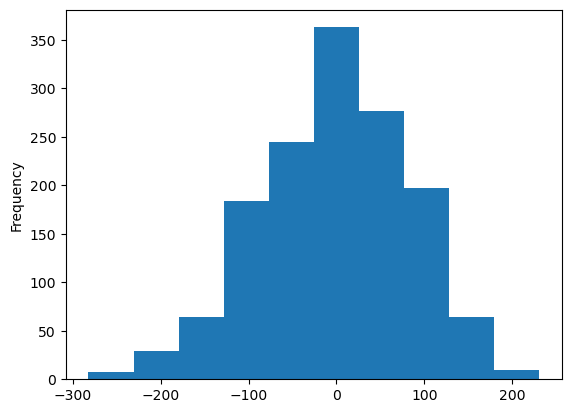

In [15]:
df['diff'].plot(kind='hist')

In [16]:
df['position'] = np.where(df['diff'] > threshold, -1, np.nan)
df['position'] = np.where(df['diff'] < threshold, 1, df['position'])
df['position'] = np.where(df['diff'] * df['diff'].shift(1) < 0, 0, df['position'])
df['position'] = df['position'].ffill().fillna(0)

In [17]:
df['price'] = gemini_data['Close']
df['returns'] = np.log(df['price'] / df['price'].shift(1))
df['strategy'] = df['position'].shift(1) * df['returns']

In [18]:
shares = 1
transaction_costs = 0.01

<AxesSubplot:xlabel='Date'>

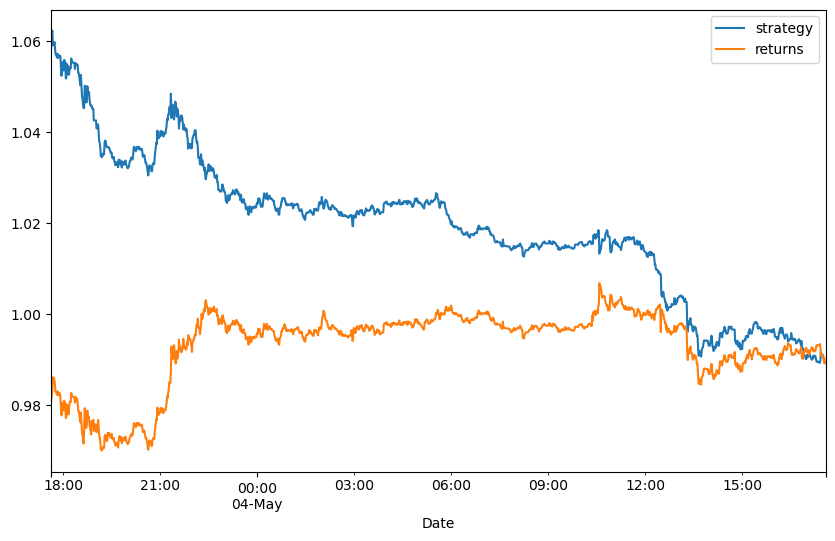

In [19]:
(df[['strategy','returns']].dropna().cumsum().apply(np.exp)*shares*(1-transaction_costs)).plot(figsize=(10,6))

In [20]:
short_x = (df['position'] < 0).to_numpy().nonzero()[0]
short = ((df['position'] < 0) * df['price'])
short_y = short[short != 0]

long_x = (df['position'] > 0).to_numpy().nonzero()[0]
long = ((df['position'] > 0) * df['price'])
long_y = long[long != 0]

In [21]:
positions = -short + long

In [22]:
# if there is a cluster of trades make toegther, only execute the first of the cluster
# this way we will not over-leverage out positions
short_ = True
long_ = True
s = np.zeros_like(df['price'])
l = np.zeros_like(df['price'])
for i in range(len(df['price'])):
    if positions.iloc[i] < 0:
        if short_:
            s[i] = True
            short_ = False
            long_ = True
    if positions.iloc[i] > 0:
        if long_:
            l[i] = True
            long_ = False
            short_ = True

In [23]:
positions = l * df['price'] - s * df['price']

In [24]:
long_x = df['price'].index[df['price'] * l != 0]
long_y = df['price'][l>0]

short_x = df['price'].index[df['price'] * s != 0]
short_y = df['price'][s>0]

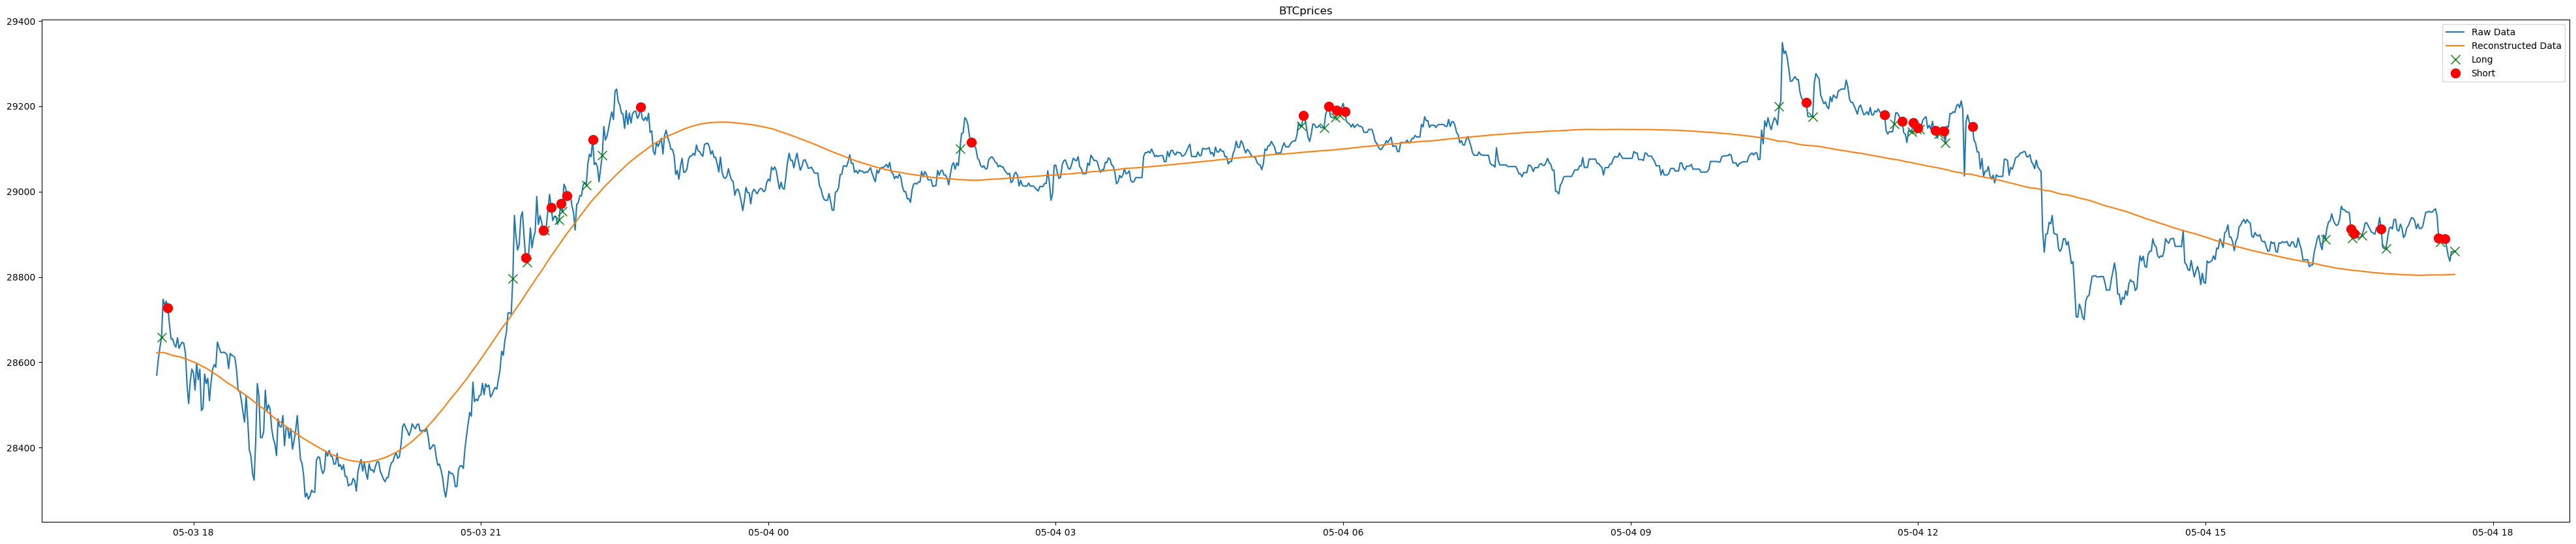

In [25]:
#start_date = '2023-03-11 00:00:00'
fig = plt.figure(figsize=(50,10))
plt.plot(df['price'], label = 'Raw Data')
plt.plot(df['reconstructed'], label = 'Reconstructed Data')
plt.plot(long_x, long_y, "x", color = 'green', markersize=10, label = "Long")
plt.plot(short_x, short_y, "o", color = 'red', markersize=10, label = "Short")
plt.title(asset+"prices")
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

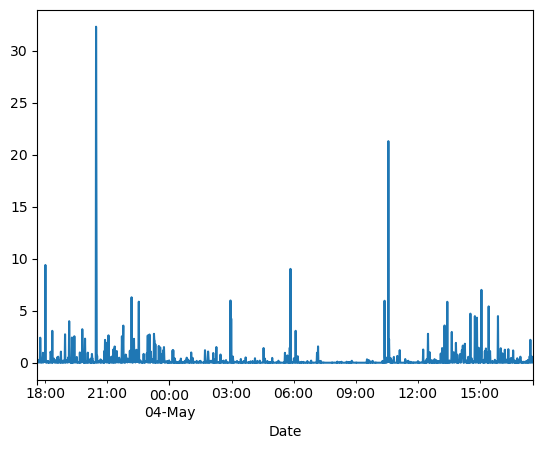

In [26]:
gemini_data['Volume'].plot()

In [27]:
trades = positions[positions != 0]

In [28]:
if len(trades) % 2 != 0:
    trades = trades[1:]

In [29]:
pnl = np.sum(shares*-trades)

In [30]:
pnl

826.5499999999956

In [31]:
trades

Date
2023-05-04 17:30:00   -28889.91
2023-05-04 17:27:00    28881.62
2023-05-04 17:26:00   -28891.19
2023-05-04 16:53:00    28866.35
2023-05-04 16:50:00   -28912.45
2023-05-04 16:38:00    28897.72
2023-05-04 16:33:00   -28902.50
2023-05-04 16:32:00    28891.56
2023-05-04 16:31:00   -28912.37
2023-05-04 16:15:00    28888.61
2023-05-04 12:34:00   -29152.16
2023-05-04 12:17:00    29113.94
2023-05-04 12:16:00   -29141.98
2023-05-04 12:13:00    29135.35
2023-05-04 12:11:00   -29142.91
2023-05-04 12:01:00    29146.26
2023-05-04 12:00:00   -29150.00
2023-05-04 11:59:00    29146.36
2023-05-04 11:57:00   -29161.49
2023-05-04 11:56:00    29140.00
2023-05-04 11:50:00   -29165.00
2023-05-04 11:45:00    29159.13
2023-05-04 11:39:00   -29179.90
2023-05-04 10:54:00    29175.88
2023-05-04 10:50:00   -29208.88
2023-05-04 10:33:00    29200.00
2023-05-04 06:01:00   -29188.31
2023-05-04 05:58:00    29177.99
2023-05-04 05:56:00   -29190.98
2023-05-04 05:55:00    29173.22
2023-05-04 05:51:00   -29199.42
202